### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


VERBOSE = 1
CV = [(slice(None), slice(None))]
TESTING = False

SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-20 11:19:52.523277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 11:19:54.819575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
ITER = 1

hyperparameterspace = {
    'epochs': ["interval-int", 1, 10],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.01],
    'model__neurons_per_layer': ["interval-int", 1, 100],
    'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [3]:
ids = [233214]#, 233211, 359935, 359952, 359940, 359931, 317614, 359949, 359934]#, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced
SPARSE_COUNTER = 0

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])
        

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            print("COUNT")
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                for _ in range(number_of_layers):
                    model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
                model.add(Dense(1, activation=None))
                # Compile model
                
                optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
                K.clear_session()
                return result
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
                K.clear_session()
                return result
            


    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = 30
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(result[2])
        SPARSE_COST_OPTIMIZED.append(result[2])

        K.clear_session()

    print(SPARSE_COUNTER)
    


######################################################################################################################################################
Current Dataset: 1 of 1 with id: 233214

################################################## Current Budget: 30 ##################################################
Performing sparse search
COUNT
Adaptive grid generation (Ritter-Novak)...


2023-04-20 11:20:05.128689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
COUNT
Done in 184479ms.
Solving linear system (automatic method)...
Done in 5ms.

Optimal hyperparameters so far:
epochs: 5.5
batch_size: 105.0
optimizer__learning_rate: 0.0001333521432163324
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.8041765052040697
Optimizing (gradient descent)...
COUNT
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 5.5
batch_size: 105.0
optimizer__learning_rate: 0.0001333521432163324
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss (Optimal value from optimization):
0.804176505204

[0.8463013123572208]
[0.8452855085303633]
[71]
Current dataset: 0 with name id: 233214


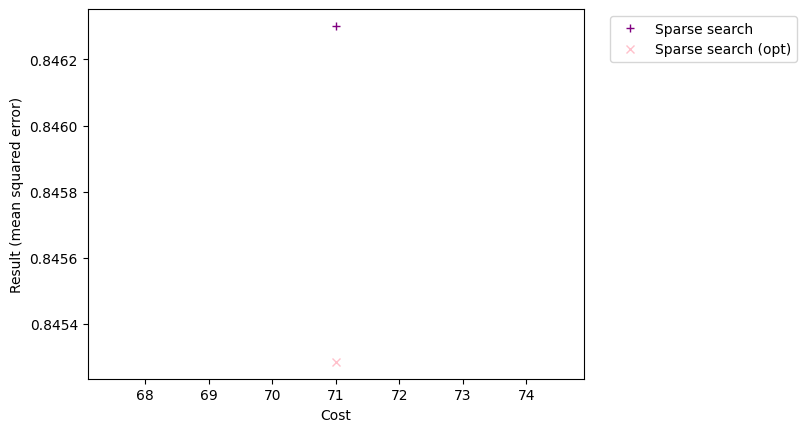

In [4]:
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
print(SPARSE_COST)


count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        plt.legend(["Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

